In [2]:
"""from google.colab import drive
drive.mount('/content/drive')

# Now you can access your Drive files using the path '/content/drive/My Drive/'
# For example, to access the "ODML" folder:
import os
odml_folder = '/content/drive/My Drive/ODML'

if os.path.exists(odml_folder):
  print(f"Successfully connected to '{odml_folder}'")
else:
  print(f"Could not find '{odml_folder}'")


# Change directory to the ODML folder
os.chdir(odml_folder)
!pip install torchprofile"""

'from google.colab import drive\ndrive.mount(\'/content/drive\')\n\n# Now you can access your Drive files using the path \'/content/drive/My Drive/\'\n# For example, to access the "ODML" folder:\nimport os\nodml_folder = \'/content/drive/My Drive/ODML\'\n\nif os.path.exists(odml_folder):\n  print(f"Successfully connected to \'{odml_folder}\'")\nelse:\n  print(f"Could not find \'{odml_folder}\'")\n\n\n# Change directory to the ODML folder\nos.chdir(odml_folder)\n!pip install torchprofile'

In [3]:
!pip install torchprofile

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import time
import os
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import pandas as pd
from torch import nn
from torch import optim
from torch.nn import functional as F
import torch.utils.data as data

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import torchprofile

In [6]:
train_dir = "/content/drive/MyDrive/2024_fall/On-device ML/labs/lab2data/sign_mnist_train.csv"
test_dir = "/content/drive/MyDrive/2024_fall/On-device ML/labs/lab2data/sign_mnist_test.csv"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
import torch
from torch.utils import data

class SignLanguageDataset(data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        label = self.df.iloc[index, 0]
        img = self.df.iloc[index, 1:].values.astype('uint8').reshape(28, 28)

        if self.transform is not None:
            img = self.transform(img)
        else:
            img = torch.from_numpy(img).unsqueeze(0).float()

        return img, label


In [8]:
# Normalizing the data and transforming it to tensor
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Lambda(lambda img: img.convert('RGB')),  # Convert grayscale to RGB
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the data
train_df = pd.read_csv(train_dir)
test_df = pd.read_csv(test_dir)

# Split the data into train and eval
ratio = 0.8
train_df, eval_df = train_df[:int(ratio*len(train_df))], train_df[int(ratio*len(train_df)):]

# Print all labels
print(sorted(train_df['label'].unique()), len(train_df['label'].unique()))
print(sorted(eval_df['label'].unique()), len(eval_df['label'].unique()))

train_dataset = SignLanguageDataset(train_df, transform=transform)
eval_dataset = SignLanguageDataset(eval_df, transform=transform)
test_dataset = SignLanguageDataset(test_df, transform=transform)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24] 24
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24] 24


In [9]:
from torch.utils.data import DataLoader

def check_image_size(dataset, num_samples=5):
    loader = DataLoader(dataset, batch_size=1, shuffle=True)

    print("Checking image sizes...")
    for i, (image, label) in enumerate(loader):
        if i >= num_samples:  # Check only the first few samples
            break
        print(f"Image {i+1}: Size {image.size()}")

check_image_size(train_dataset, num_samples=5)  # Check the first 5 samples


Checking image sizes...
Image 1: Size torch.Size([1, 3, 28, 28])
Image 2: Size torch.Size([1, 3, 28, 28])
Image 3: Size torch.Size([1, 3, 28, 28])
Image 4: Size torch.Size([1, 3, 28, 28])
Image 5: Size torch.Size([1, 3, 28, 28])


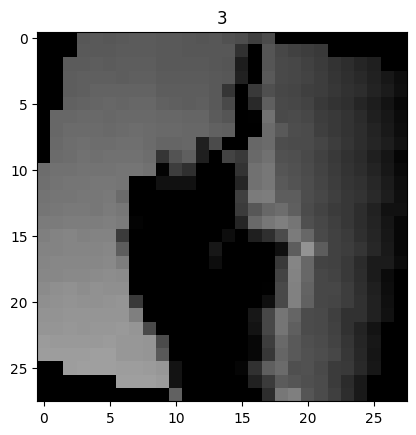

In [10]:
def show_img(img, label):
    plt.imshow(img.squeeze().permute(1, 2, 0))
    plt.title(label)
    plt.show()

show_img(*train_dataset[0])

In [11]:
# Use a pretrained ResNet model
model = models.resnet50(pretrained=True)

frozen = False
if frozen:
    for param in model.parameters():
        param.requires_grad = False

# Add a new layer to the model
last_layer_dim = model.fc.in_features
model.fc = nn.Linear(last_layer_dim, 26) # 26 classes (well excluding J and Z)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the data loaders
train_loader = data.DataLoader(train_dataset, batch_size=256, shuffle=True)
eval_loader = data.DataLoader(eval_dataset, batch_size=256, shuffle=False)
test_loader = data.DataLoader(test_dataset, batch_size=256, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for img, label in tqdm(train_loader, desc="Training"):
        img, label = img.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

    avg_loss = train_loss / len(train_loader)
    accuracy = correct / total
    return avg_loss, accuracy

def evaluate(model, eval_loader, criterion, device):
    model.eval()
    eval_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for img, label in tqdm(eval_loader, desc="Evaluating"):
            img, label = img.to(device), label.to(device)
            output = model(img)
            loss = criterion(output, label)
            eval_loss += loss.item()
            _, predicted = torch.max(output, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()

    avg_loss = eval_loss / len(eval_loader)
    accuracy = correct / total
    return avg_loss, accuracy

def test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for img, label in tqdm(test_loader, desc="Testing"):
            img, label = img.to(device), label.to(device)
            output = model(img)
            loss = criterion(output, label)
            test_loss += loss.item()
            _, predicted = torch.max(output, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()

    avg_loss = test_loss / len(test_loader)
    accuracy = correct / total
    return avg_loss, accuracy

In [13]:
# Training loop
n_epochs = 5 if str(device) == 'cuda' else 2
train_losses = []
eval_losses = []
train_acc = []
eval_acc = []

model.to(device)

for epoch in range(n_epochs):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device)
    eval_loss, eval_accuracy = evaluate(model, eval_loader, criterion, device)

    train_losses.append(train_loss)
    train_acc.append(train_accuracy)
    eval_losses.append(eval_loss)
    eval_acc.append(eval_accuracy)

    print(f"Epoch {epoch+1}/{n_epochs}")
    print(f"Train Loss: {train_loss:.3f} | Train Accuracy: {train_accuracy:.3f}")
    print(f"Eval Loss: {eval_loss:.3f} | Eval Accuracy: {eval_accuracy:.3f}")

test_loss, test_accuracy = test(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.3f} | Test Accuracy: {test_accuracy:.3f}")

Evaluating: 100%|██████████| 22/22 [00:05<00:00,  4.22it/s]


Epoch 1/5
Train Loss: 0.764 | Train Accuracy: 0.749
Eval Loss: 0.304 | Eval Accuracy: 0.904


Evaluating: 100%|██████████| 22/22 [00:05<00:00,  3.99it/s]


Epoch 2/5
Train Loss: 0.139 | Train Accuracy: 0.957
Eval Loss: 0.077 | Eval Accuracy: 0.979


Evaluating: 100%|██████████| 22/22 [00:04<00:00,  4.55it/s]


Epoch 3/5
Train Loss: 0.080 | Train Accuracy: 0.975
Eval Loss: 0.088 | Eval Accuracy: 0.973


Evaluating: 100%|██████████| 22/22 [00:04<00:00,  4.54it/s]


Epoch 4/5
Train Loss: 0.065 | Train Accuracy: 0.979
Eval Loss: 0.158 | Eval Accuracy: 0.958


Evaluating: 100%|██████████| 22/22 [00:05<00:00,  3.95it/s]


Epoch 5/5
Train Loss: 0.055 | Train Accuracy: 0.984
Eval Loss: 0.095 | Eval Accuracy: 0.980


Testing: 100%|██████████| 29/29 [00:06<00:00,  4.48it/s]

Test Loss: 0.133 | Test Accuracy: 0.961


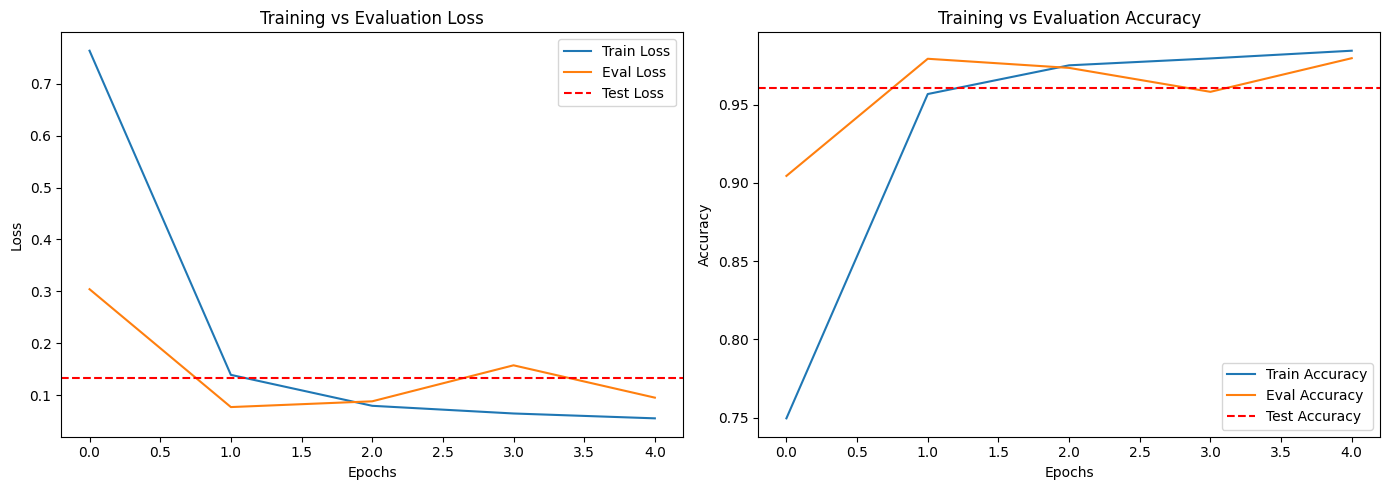

In [14]:
# Create a 1x2 subplot to display the loss and accuracy side by side
plt.figure(figsize=(14, 5))

# Plot the training and evaluation loss on the left
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(eval_losses, label='Eval Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Evaluation Loss')
plt.legend()

# Plot the training and evaluation accuracy on the right
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(eval_acc, label='Eval Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Evaluation Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [15]:
def measure_inference_latency(model, data_loader, device):
    model.eval()
    total_time = 0.0
    warmup = True

    with torch.no_grad():
        for i, (img, label) in enumerate(data_loader):
            img = img.to(device)
            start_time = time.time()

            # Forward pass
            model(img)

            # Record time
            latency = time.time() - start_time

            # Skip the warmup run
            if warmup:
                warmup = False
                continue

            total_time += latency

    avg_latency = total_time / (len(data_loader) - 1)  # Exclude warmup
    return avg_latency

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_flops(model, data_loader, device):
    model.eval()
    img, _ = next(iter(data_loader))  # Get one batch
    img = img.to(device)

    # Profile FLOPs
    flops = torchprofile.profile_macs(model, img)
    return flops

In [16]:
# Calculate the number of parameters, FLOPs, and inference latency
n_params = count_parameters(model)
flops = count_flops(model, test_loader, device)
latency = measure_inference_latency(model, test_loader, device)

print(f"Number of Parameters: {n_params}")
print(f"Number of FLOPs: {flops}")
print(f"Average Inference Latency: {latency:.6f} seconds")

Number of Parameters: 23561306
Number of FLOPs: 20330315776
Average Inference Latency: 0.008913 seconds


In [17]:
!pip install codecarbon

In [44]:
import time
import torch
from codecarbon import EmissionsTracker

def measure_inference_energy_and_carbon(model, data_loader, device):
    model.eval()
    warmup = True

    # Create EmissionsTracker instance
    tracker = EmissionsTracker()

    total_energy_kwh=0
    total_carbon_kg=0

    with torch.no_grad():
        # Start tracking energy and carbon emissions
        tracker.start()

        for i, (img, label) in enumerate(data_loader):
            img = img.to(device)

            model(img)

            if warmup:
                warmup = False
                continue

        # Stop tracking and get emissions report
        emissions_data = tracker.stop()

    total_emission=tracker.flush()
    return total_emission, total_emission / (len(data_loader) - 1)


total_carbon_emission, avg_carbon_emission= measure_inference_energy_and_carbon(model, test_loader, device)



[codecarbon INFO @ 17:41:01] [setup] RAM Tracking...
[codecarbon INFO @ 17:41:01] [setup] GPU Tracking...
[codecarbon INFO @ 17:41:01] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 17:41:01] [setup] CPU Tracking...
[codecarbon WARNING @ 17:41:01] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU

[codecarbon WARNING @ 17:41:02] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 17:41:02] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 17:41:02] >>> Tracker's metadata:
[codecarbon INFO @ 17:41:02]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 17:41:02]   Python version: 3.10.12
[codecarbon INFO @ 17:41:02]   CodeCarbon version: 2.7.1
[codecarbon INFO @ 17:41:02]   Available RAM : 12.675 GB
[codecarbon INFO @ 17:41:02]   CPU count: 2
[codeca

In [45]:
total_carbon_emission, avg_carbon_emission

(4.6775389626220324e-05, 1.6705496295078687e-06)

In [46]:
import pandas as pd
df=pd.read_csv('emissions.csv')
print("total emission",df['emissions'][len(df)-1],"kg" ) #noted as emissions on emissions.csv
print("total electricity consumed",df['energy_consumed'][len(df)-1], "kWh") # energy_consumed in csv = total reported kwh of electricity used since beginning

print("average emission",df['emissions'][len(df)-1]/(len(test_loader)-1),"kg" ) #noted as emissions on emissions.csv
print("average electricity consumed",df['energy_consumed'][len(df)-1]/(len(test_loader)-1), "kWh")


total emission 4.677538962622032e-05 kg
total electricity consumed 0.0001339400894073 kWh
average emission 1.6705496295078685e-06 kg
average electricity consumed 4.783574621689286e-06 kWh


Base (Resnet50)

-Input size	: torch.Size([1, 3, 28, 28]

-Number of parameters	: 23561306

-Energy (kWh)	: 4.783574621689286e-06 kWh

-Carbon emissions (kg): 1.6705496295078685e-06 kg




Smaller input (Resnet50, ?)



Fewer parameters (Resnet18, torch.Size([1, 3, 28, 28])